# Inertial Navigation
## Orientation Estimation

In this session we will use data from an accelerometer and from a gyroscope in order to estimate the orientation of a device in space.

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate
from scipy.integrate import cumtrapz as trapz

In [93]:
# Constants
RAD_2_DEG = 360 / (2*np.pi)
N = 250
T_end = 10.
h = T_end/N

# Accel noise
accel_var = 0.025
gyro_var = 0.05

The axes are chosen such that rotation around X is roll, around Y is pitch, around Z is yaw.

The reading from the accel of a certain axis will be unchanged under rotation around that axis.

We will simulate a situation in which a device is initially flat, so that the gravity vector is $a=\begin{bmatrix} a_x & a_y & a_z \end{bmatrix} = \begin{bmatrix} 0& 0&g \end{bmatrix}$, followed by a rotation around the x axis (a **roll** by definition) so that $a= \begin{bmatrix} 0& g&0 \end{bmatrix}$ and back again.

[  0.     0.04   0.08   0.12   0.16   0.2    0.24   0.28   0.32   0.36
   0.4    0.44   0.48   0.52   0.56   0.6    0.64   0.68   0.72   0.76
   0.8    0.84   0.88   0.92   0.96   1.     1.04   1.08   1.12   1.16
   1.2    1.24   1.28   1.32   1.36   1.4    1.44   1.48   1.52   1.56
   1.6    1.64   1.68   1.72   1.76   1.8    1.84   1.88   1.92   1.96   2.
   2.04   2.08   2.12   2.16   2.2    2.24   2.28   2.32   2.36   2.4
   2.44   2.48   2.52   2.56   2.6    2.64   2.68   2.72   2.76   2.8
   2.84   2.88   2.92   2.96   3.     3.04   3.08   3.12   3.16   3.2
   3.24   3.28   3.32   3.36   3.4    3.44   3.48   3.52   3.56   3.6
   3.64   3.68   3.72   3.76   3.8    3.84   3.88   3.92   3.96   4.     4.04
   4.08   4.12   4.16   4.2    4.24   4.28   4.32   4.36   4.4    4.44
   4.48   4.52   4.56   4.6    4.64   4.68   4.72   4.76   4.8    4.84
   4.88   4.92   4.96   5.     5.04   5.08   5.12   5.16   5.2    5.24
   5.28   5.32   5.36   5.4    5.44   5.48   5.52   5.56   5.6    5.6

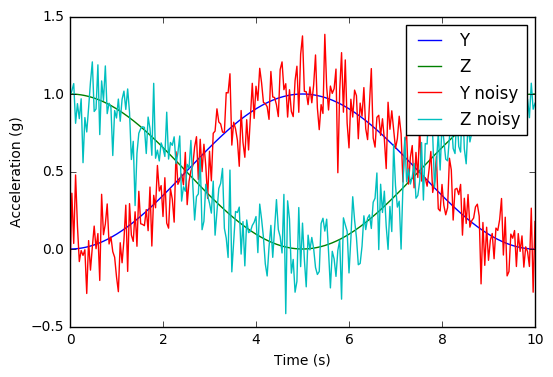

In [94]:
# Time vector
time = np.linspace(0, T_end, N+1)
accz = 0.5 + 0.5 * np.cos(.2*np.pi*time)
accy = 1-accz
accy_noisy = accy + np.sqrt(accel_var) * np.random.randn(N+1)
accz_noisy = accz + np.sqrt(accel_var) * np.random.randn(N+1)

print time

plt.plot(time, accy)
plt.plot(time, accz)
plt.plot(time, accy_noisy)
plt.plot(time, accz_noisy)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend(['Y', 'Z', 'Y noisy', 'Z noisy'])
plt.show()

We can use these readings to estimate the **roll** angle, since $\large \theta = \tan^{-1} \left ( \frac{a_y}{a_z} \right )$

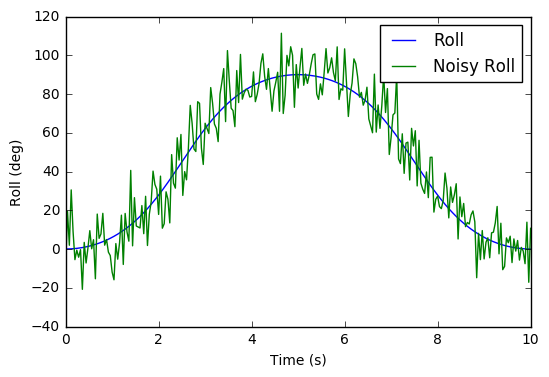

In [95]:
roll = np.arctan2(accy, accz)
roll_noisy = np.arctan2(accy_noisy, accz_noisy)
plt.plot(time, roll * RAD_2_DEG)
plt.plot(time, roll_noisy * RAD_2_DEG)
plt.legend(['Roll', 'Noisy Roll'])
plt.xlabel('Time (s)')
plt.ylabel('Roll (deg)')
plt.show()

### Gyroscope

The gyro measures the **rate of rotation around each axis**. A roll (remember: rotation around the x axis) therefore results in non-zero measurements on the gyro x-axis.

The gyro is subject to noise (though not as much as the accelerometer) but also to **rate bias**, meaning that

$\large \dot{\theta}_{measured} = \dot{\theta}_{true} + \dot{\theta}_{bias}$

where $\large \dot{\theta}_{bias}$ is **not zero mean** and additionally **varies with time**.

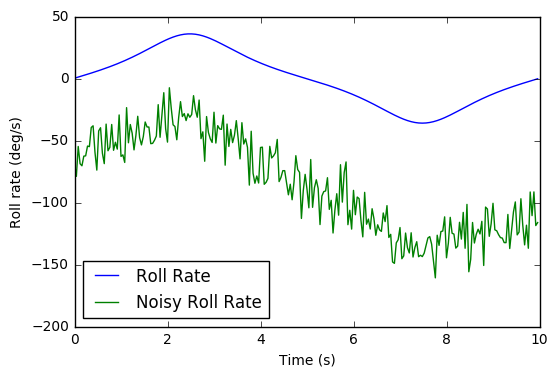

In [132]:
# Gyro information for roll (rotation around X-axis)
roll_rate = 1/h * np.diff(roll)

# Gyro bias (constant rate bias = increasing position bias)
gyro_rate_bias = -1 - 0.1 * time[0:N]
roll_rate_noisy = roll_rate + gyro_rate_bias + np.sqrt(gyro_var) * np.random.randn(N)

plt.plot(time[0:N], roll_rate * RAD_2_DEG)
plt.plot(time[0:N], roll_rate_noisy * RAD_2_DEG)
plt.legend(['Roll Rate', 'Noisy Roll Rate'], loc=3)
plt.xlabel('Time (s)')
plt.ylabel('Roll rate (deg/s)')
plt.show()

If we just integrate the noisy and biased gyro, this is what happens:

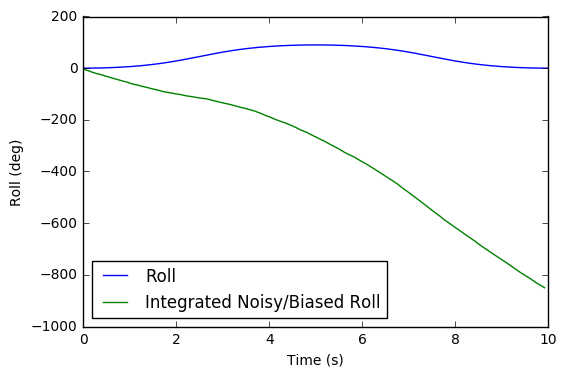

In [133]:
# Integrate noisy gyro
roll_gyro_integ = trapz(roll_rate_noisy, time[0:N])
plt.plot(time, roll * RAD_2_DEG)
plt.plot(time[0:N-1], roll_gyro_integ* RAD_2_DEG)
plt.xlabel('Time (s)')
plt.ylabel('Roll (deg)')
plt.legend(['Roll', 'Integrated Noisy/Biased Roll'], loc=3)
plt.show()

### Kalman Filter

We will again apply the Kalman filter to **fuse** the data we have from the noisy but non-drifting accelerometer with the less noisy but drifting data from the gyro.

Let our **state vector** be $\large x = \begin{bmatrix} \theta \\ \dot{\theta}_{measured} \\ \dot{\theta}_{bias} \end{bmatrix}$.

How does roll change with roll rate?
$\large \theta_k = \theta_{k-1} + (\dot{\theta}_{measured}- \dot{\theta}_{bias}) \Delta t$

We have no knowledge of how $\large \dot{\theta}_{bias}$ will change so we will assume
$\large \dot{\theta}_{bias,k} = \dot{\theta}_{bias,k-1}$

This gives us

$\large F= \begin{bmatrix} 1 & \Delta t & -\Delta t \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$

so that

$\large x_{k+1} = Fx_k$

and we measure the angle and rate of rotation, so

$\large H = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}$.

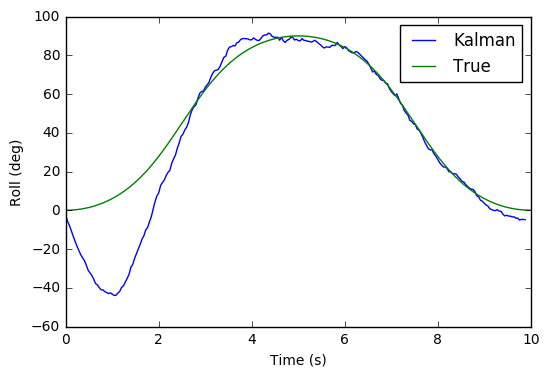

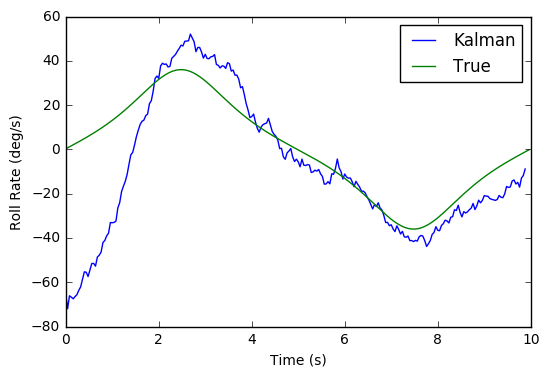

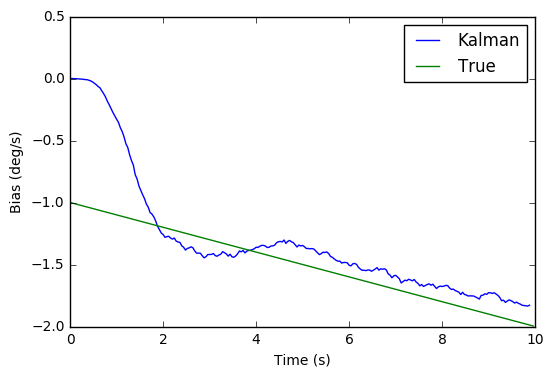

In [150]:
# Initial state
x = np.array([0, 0, 0]).T

# Noise covariance matrices
Q = np.array([[0, 0, 0], [0, 1e-3, 0], [0, 0, 1]])
R = np.array([[accel_var*1e4, 0], [0, gyro_var]])

P = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 1]])

# State is [theta, theta_dot_bias]
# Update with x+ = F*x + B*u
F = np.array([[1, h, -h], [0, 1, 0], [0, 0, 1]])

# Measurement (only measure angle)
H = np.array([[1, 0, 0], [0, 1, 0]])

# Store results
xstore = np.zeros([3, N-2])

for k in range(N-2):
    # Predict
    xp = F.dot(x)
    Pp = F.dot(P).dot(F.T) + Q
    
    # Update
    y = np.array([roll_noisy[k], roll_rate_noisy[k]])
    r = y - H.dot(xp)
    S = H.dot(Pp).dot(H.T) + R
    K = Pp.dot(H.T).dot(np.linalg.matrix_power(S, -1))
    x = xp + K.dot(r)
    P = (np.eye(3) - K.dot(H)).dot(Pp)

    # Store
    xstore[:,k] = x
    
plt.plot(time[0:N-2], xstore[0,:] * RAD_2_DEG)
plt.plot(time, roll * RAD_2_DEG)
plt.xlabel('Time (s)')
plt.ylabel('Roll (deg)')
plt.legend(['Kalman', 'True'])
plt.show()

plt.plot(time[0:N-2], (xstore[1,:] - xstore[2,:]) * RAD_2_DEG)
plt.plot(time[0:N], roll_rate * RAD_2_DEG)
plt.xlabel('Time (s)')
plt.ylabel('Roll Rate (deg/s)')
plt.legend(['Kalman', 'True'])
plt.show()

plt.plot(time[0:N-2], xstore[2,:])
plt.plot(time[0:N], gyro_rate_bias)
plt.xlabel('Time (s)')
plt.ylabel('Bias (deg/s)')
plt.legend(['Kalman', 'True'])
plt.show()